In [1]:
import pickle

import numpy as np
import tensorly as tl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from tensorly.metrics import congruence_coefficient

In [2]:
fmss_A = {}
fmss_CB = {}

repeats = 10
gender = 'males'

for model in ['cmf','parafac2','cp']:
    for no_of_components in [2,3,4,5,6,7,8]:
        for l_B in [0.0]:
            for splits in [10]:
                try:

                    with open(f"Metabolomics/results/replicability/factors_{model}_{no_of_components}_components_l_B_{l_B}_splits_{splits}_{gender}.pkl", "rb") as f:
                        args = pickle.load(f)

                    fmss_A[f'{model}_{no_of_components}_{l_B}_{splits}'] = []
                    fmss_CB[f'{model}_{no_of_components}_{l_B}_{splits}'] = []

                    seen_pairs = set()

                    for r in range(repeats):
                        for s in range(splits):

                            # Get the target factors2compare once for this (r, s)
                            thing2compare = next((arg["factors"],arg["sorted_train_index"]) for arg in args if arg["r"] == r and arg["s"] == s)
                            factors2compare = thing2compare[0]
                            sorted_train_index2compare = thing2compare[1]

                            idx_ref = (r, s)

                            for arg in args:
                                idx_cmp = (arg["r"], arg["s"])
                                if arg["r"] == r and arg["s"] != s:
                                    # Sort to form an unordered pair key to avoid double counting
                                    pair_key = tuple(sorted([idx_ref, idx_cmp]))

                                    if pair_key not in seen_pairs:

                                        factors2comparewith = arg["factors"]
                                        sorted_train_index2comparewith = arg["sorted_train_index"]

                                        if factors2comparewith is None or factors2compare is None:
                                            continue

                                        # Find common indices
                                        common_indices = sorted(set(sorted_train_index2compare).intersection(set(sorted_train_index2comparewith)))

                                        subjects2use1 = []
                                        subjects2use2 = []

                                        for common_idx in common_indices:
                                            subjects2use1.append(sorted_train_index2compare.index(common_idx))
                                            subjects2use2.append(sorted_train_index2comparewith.index(common_idx))

                                        if common_indices == []:
                                            print("No common subjects found!")

                                        if model != 'cp':

                                            A1 = deepcopy(factors2compare[2])
                                            A2 = deepcopy(factors2comparewith[2])

                                            B1 = [deepcopy(factors2compare[1][i]) for i in subjects2use1]
                                            B2 = [deepcopy(factors2comparewith[1][i]) for i in subjects2use2]

                                            C1 = deepcopy(factors2compare[0][subjects2use1,:])
                                            C2 = deepcopy(factors2comparewith[0][subjects2use2,:])

                                            K = C1.shape[0]
                                            R = C1.shape[1]

                                        else:

                                            A1 = deepcopy(factors2compare[2])
                                            A2 = deepcopy(factors2comparewith[2])

                                            B1 = deepcopy(factors2compare[1])
                                            B2 = deepcopy(factors2comparewith[1])

                                            C1 = deepcopy(factors2compare[0][subjects2use1,:])
                                            C2 = deepcopy(factors2comparewith[0][subjects2use2,:])

                                            K = C1.shape[0]
                                            R = C1.shape[1]

                                        CB1 = deepcopy(B1)
                                        CB2 = deepcopy(B2)

                                        if model == 'parafac2':

                                            for comp in range(R):
                                                for k in range(K):
                                                    normm = tl.norm(CB1[k][:,comp])
                                                    CB1[k][:,comp] /= normm
                                                    normm = tl.norm(CB2[k][:,comp])
                                                    CB2[k][:,comp] /= normm

                                            for comp in range(R):
                                                C1[:,comp] /= tl.norm(C1[:,comp])
                                                C2[:,comp] /= tl.norm(C2[:,comp])

                                            for comp in range(R):
                                                for k in range(K):
                                                    CB1[k][:, comp] *= C1[k,comp]
                                                    CB2[k][:, comp] *= C2[k,comp]

                                        elif model == 'cmf':

                                            for comp in range(R):
                                                for k in range(K):
                                                    normm = tl.norm(CB1[k][:,comp])
                                                    CB1[k][:,comp] /= normm
                                                    C1[k,comp] *= normm
                                                    normm = tl.norm(CB2[k][:,comp])
                                                    CB2[k][:,comp] /= normm
                                                    C2[k,comp] *= normm

                                                normm2 = tl.norm(A1[:,comp])
                                                C1[:,comp] *= normm2
                                                normm2 = tl.norm(A2[:,comp])
                                                C2[:,comp] *= normm2

                                            for comp in range(R):
                                                C1[:,comp] /= tl.norm(C1[:,comp])
                                                C2[:,comp] /= tl.norm(C2[:,comp])

                                            for comp in range(R):
                                                for k in range(K):
                                                    CB1[k][:, comp] *= C1[k, comp]
                                                    CB2[k][:, comp] *= C2[k, comp]

                                        elif model == 'cp':

                                            CB1 = [deepcopy(CB1) for _ in range(K)]
                                            CB2 = [deepcopy(CB2) for _ in range(K)]

                                            for comp in range(R):
                                                for k in range(K):
                                                    normm = tl.norm(CB1[k][:,comp])
                                                    CB1[k][:,comp] /= normm
                                                    normm = tl.norm(CB2[k][:,comp])
                                                    CB2[k][:,comp] /= normm

                                            for comp in range(R):
                                                C1[:,comp] /= tl.norm(C1[:,comp])
                                                C2[:,comp] /= tl.norm(C2[:,comp])

                                            for comp in range(R):
                                                for k in range(K):
                                                    CB1[k][:, comp] *= C1[k,comp]
                                                    CB2[k][:, comp] *= C2[k,comp]   

                                        CB1 = np.vstack(CB1)
                                        CB2 = np.vstack(CB2)

                                        fmss_A[f'{model}_{no_of_components}_{l_B}_{splits}'].append(congruence_coefficient(A1,A2)[0])
                                        fmss_CB[f'{model}_{no_of_components}_{l_B}_{splits}'].append(congruence_coefficient(CB1,CB2)[0])
                                        seen_pairs.add(deepcopy(pair_key))

                    print(f"Succesfully loaded {model}_{no_of_components}_{l_B}_{splits}: {len(fmss_A[f'{model}_{no_of_components}_{l_B}_{splits}'])}")

                except Exception as e:
                    print(f'Error loading {model}_{no_of_components}_{l_B}: {e}')

Succesfully loaded cmf_2_0.0_10: 450
Succesfully loaded cmf_3_0.0_10: 450
Succesfully loaded cmf_4_0.0_10: 450
Succesfully loaded cmf_5_0.0_10: 450
Succesfully loaded cmf_6_0.0_10: 450
Succesfully loaded cmf_7_0.0_10: 450
Succesfully loaded cmf_8_0.0_10: 450
Succesfully loaded parafac2_2_0.0_10: 450
Succesfully loaded parafac2_3_0.0_10: 450
Succesfully loaded parafac2_4_0.0_10: 450
Succesfully loaded parafac2_5_0.0_10: 450
Succesfully loaded parafac2_6_0.0_10: 450
Succesfully loaded parafac2_7_0.0_10: 450
Succesfully loaded parafac2_8_0.0_10: 230
Succesfully loaded cp_2_0.0_10: 450
Succesfully loaded cp_3_0.0_10: 450
Succesfully loaded cp_4_0.0_10: 450
Succesfully loaded cp_5_0.0_10: 450
Succesfully loaded cp_6_0.0_10: 450
Succesfully loaded cp_7_0.0_10: 450
Succesfully loaded cp_8_0.0_10: 450


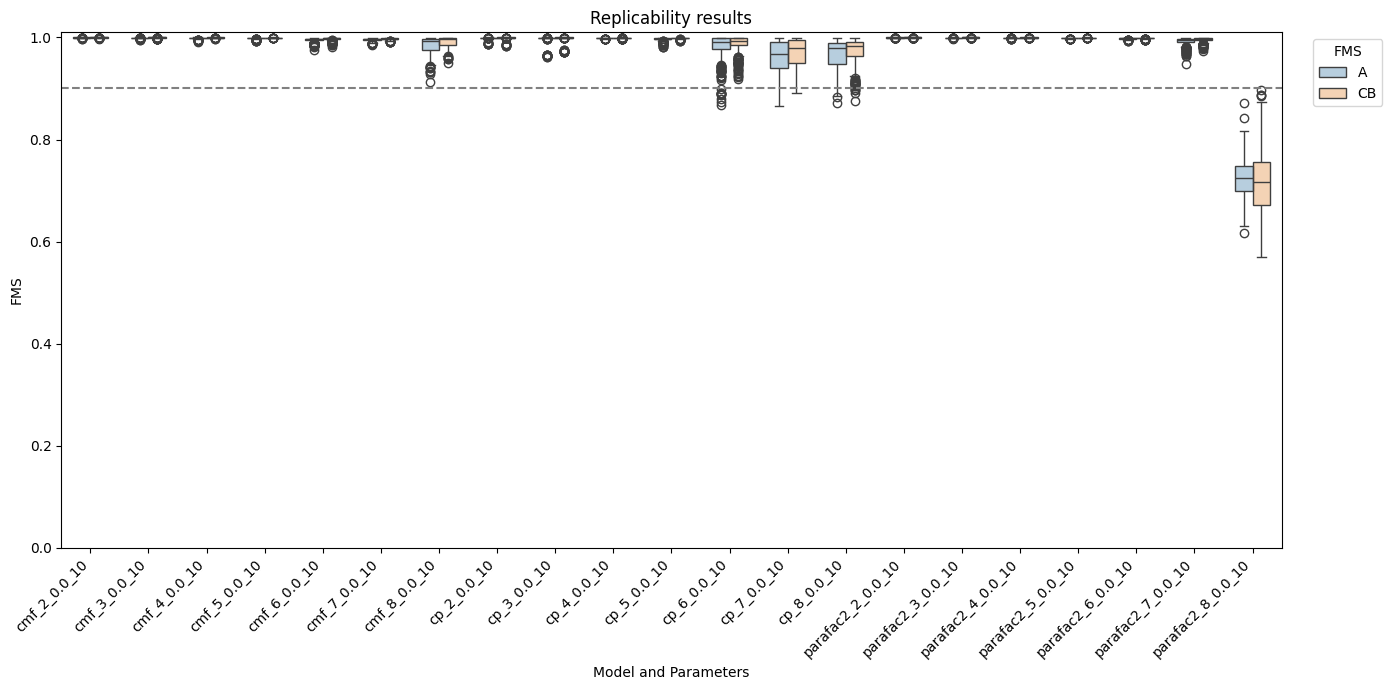

In [4]:

# Prepare data for seaborn
data = []
for key, values in fmss_A.items():
    model, r, l_B,splits = key.split('_')
    r = int(r)
    l_B = float(l_B)
    for v in values:
        data.append({'FMS A': v, 'model': model, 'r': r, 'l_B': l_B, 'splits': splits, 'label': key})

df = pd.DataFrame(data)

# --- build df_CB from ordered_dict_CB in the same way ---
data_cb = []
for key, values in fmss_CB.items():
    model, r, l_B, splits = key.split('_')
    r = int(r); l_B = float(l_B)
    for v in values:
        data_cb.append({'FMS CB': v, 'model': model, 'r': r, 'splits': splits, 'l_B': l_B, 'label': key})
df_cb = pd.DataFrame(data_cb)

# --- align keys/checks (optional but robust) ---
missing_in_cb = sorted(set(df['label']) - set(df_cb['label']))
missing_in_a  = sorted(set(df_cb['label']) - set(df['label']))
if missing_in_cb:
    print("Warning: labels missing in CB:", missing_in_cb)
if missing_in_a:
    print("Warning: labels missing in A:", missing_in_a)

# --- melt to long format with a 'metric' column ---
dfa = df.rename(columns={'FMS A': 'value'}).assign(metric='A')[['label','model','r','l_B','metric','value']]
dfc = df_cb.rename(columns={'FMS CB': 'value'}).assign(metric='CB')[['label','model','r','l_B','metric','value']]
df_long = pd.concat([dfa, dfc], ignore_index=True)

# consistent x order (optional: sort by model,r,l_B)
order = (df_long[['label','model','r','l_B']]
         .drop_duplicates()
         .sort_values(['model','r','l_B'])['label']
         .tolist())

dfa.to_pickle(f"Metabolomics/df_A_replic_{gender}.pkl")
dfc.to_pickle(f"Metabolomics/df_CB_replic_{gender}.pkl")

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(14, 7))
plt.ylim([0.6, 1.005])

# Two boxes per label: hue = metric
ax = sns.boxplot(
    data=df_long, x='label', y='value', hue='metric',
    showfliers=True, width=0.6, order=order
)

# Make the boxes semi-transparent
for patch in ax.patches:  # PathPatches
    r, g, b, _ = mpl.colors.to_rgba(patch.get_facecolor())
    patch.set_facecolor((r, g, b, 0.35))

# Single legend (for metric)
handles, labels = ax.get_legend_handles_labels()
# first k handles/labels correspond to 'metric' from the first layer (boxplot)
k = df_long['metric'].nunique()  # should be 2
ax.legend(handles[:k], labels[:k], title="FMS", bbox_to_anchor=(1.02, 1), loc="upper left")

ax.axhline(y=0.9, color='gray', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.title('Replicability results')
plt.ylabel('FMS')
plt.ylim([0,1.01])
plt.xlabel('Model and Parameters')
plt.tight_layout()
plt.show()